In [6]:
# %pip install tensorflow
# %pip install xgboost
# %pip install lightgbm
# %pip install matplotlib

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    average_precision_score,
    accuracy_score,
    brier_score_loss
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

np.random.seed(42)

In [8]:
DATA_DIR = Path("data/processed")
events_path = DATA_DIR / "ad_events_processed.csv"

events_df = pd.read_csv(events_path)
events_df.head()

,user_id,ad_id,user_age_bucket,user_location,user_device,user_base_ctr,ad_category,ad_quality_score,ad_base_ctr,bid,time_of_day,interest_match,true_ctr,clicked
0,46993,646,35-44,Tier-3,android,0.031010,fashion,0.852224,0.037387,1.79,morning,0,0.600000,1
1,15268,707,25-34,Tier-2,android,0.039462,electronics,0.588347,0.025422,4.95,evening,0,0.575525,1
2,65066,552,35-44,Tier-2,android,0.023422,fashion,0.818090,0.052376,3.24,morning,0,0.600000,0
3,26740,640,25-34,Tier-2,ios,0.047996,electronics,0.838686,0.040108,2.28,evening,0,0.600000,1
4,69272,643,25-34,Tier-2,ios,0.054098,electronics,0.711505,0.041477,4.70,evening,0,0.600000,1


In [9]:
target_col = "clicked"

feature_cols = [
    "user_age_bucket",
    "user_location",
    "user_device",
    "user_base_ctr",
    "ad_category",
    "ad_quality_score",
    "ad_base_ctr",
    "bid",
    "time_of_day",
    "interest_match",
]

X = events_df[feature_cols].copy()
y = events_df[target_col].astype(int)

X.shape, y.shape, y.mean()

((2000000, 10), (2000000,), np.float64(0.5737585))

In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,     
    random_state=42,
    stratify=y_temp,
)

X_train.shape, X_val.shape, X_test.shape

((1200000, 10), (400000, 10), (400000, 10))

In [11]:
categorical_features = [
    "user_age_bucket",
    "user_location",
    "user_device",
    "ad_category",
    "time_of_day",
]

numeric_features = [
    "user_base_ctr",
    "ad_quality_score",
    "ad_base_ctr",
    "bid",
    "interest_match",
]

categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",                #if an unknown Value comes over just ignore and fill 0s everywhere
    sparse_output=False,                    # return a dense numpy array rather than a sparse matrix
)

numeric_transformer = StandardScaler()      #Puts the data value b/w 0-1

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features),
    ]
)

In [12]:
def evaluate_model(name, model, X_tr, y_tr, X_v, y_v):
    y_tr_proba = model.predict_proba(X_tr)[:,1]
    y_v_proba = model.predict_proba(X_v)[:,1]

    y_tr_pred = (y_tr_proba >= 0.5).astype(int)
    y_v_pred = (y_v_proba >= 0.5).astype(int)

    metrics = {
        "model": name,
        "train_auc": roc_auc_score(y_tr, y_tr_proba),
        "val_auc": roc_auc_score(y_v, y_v_proba),
        "train_logloss": log_loss(y_tr, y_tr_proba),
        "val_logloss": log_loss(y_v, y_v_proba),
        "train_pr_auc": average_precision_score(y_tr, y_tr_proba),
        "val_pr_auc": average_precision_score(y_v, y_v_proba),
        "train_acc": accuracy_score(y_tr, y_tr_pred),
        "val_acc": accuracy_score(y_v, y_v_pred),
        "val_brier": brier_score_loss(y_v, y_v_proba),  #Gives Calibration — how close predicted CTR probability is to true CTR.
    }

    return metrics


#### Defining Models

In [14]:
models = {}

log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced",
)

models["log_reg"] = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", log_reg)
    ]
)

random_forest = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

models["random_forest"] = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", random_forest)
    ]
)

xgb = XGBClassifier(
    n_estimators  =400,
    max_depth = 6,
    learning_rate = 0.05,
    subsample = 0.8,                 #Here we're using only 80% rows at any given time to make sure model is not overfitting and has randomness.
    colsample_bytree = 0.8,          #This makes sure to only take 80% features at once so we have reduced overfitting, diverse trees and more generalisation
    eval_metrics = "logloss",        # can be logloss, auc, error or rmse
    tree_method = "hist",            # Gives an idea on how to split the trees
    n_jobs = -1,
    random_state = 42
)

models["xgboost"] = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb)
    ]
)

lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=64,                  #Controls tree complexity - LGBM grows trees using leaf-wise strategy (too many leaves are overfitting and too less are underfitting)
    subsample=0.8,                  
    colsample_bytree=0.8,
    objective="binary",             #loss funtion - binary click (0,1) so binary log loss plus sigmoidal prob output
    n_jobs= -1,
    random_state=42,
)

models["lightgbm"] = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", lgbm),
    ]
)

list(models.keys())


['log_reg', 'random_forest', 'xgboost', 'lightgbm']

In [15]:
results = []

for name, pipe in models.items():
    print(f"Training model : {name}")

    pipe.fit(X_train, y_train)

    metrics = evaluate_model(name, pipe, X_train, y_train , X_val, y_val)
    results.append(metrics)

results_df = pd.DataFrame(results)
results_df.sort_values("val_auc", ascending=False)

Training model : log_reg
Training model : random_forest
Training model : xgboost


[15:34:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "eval_metrics" } are not used.



Training model : lightgbm
[LightGBM] [Info] Number of positive: 688511, number of negative: 511489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 1200000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573759 -> initscore=0.297205
[LightGBM] [Info] Start training from score 0.297205


/Users/utkarshsingh/ClickRank/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/utkarshsingh/ClickRank/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,train_auc,val_auc,train_logloss,val_logloss,train_pr_auc,val_pr_auc,train_acc,val_acc,val_brier
3,lightgbm,0.599306,0.547154,0.667583,0.671875,0.658405,0.598127,0.599434,0.597510,0.239516
0,log_reg,0.544766,0.546863,0.688252,0.687892,0.597595,0.599646,0.534488,0.535640,0.247401
2,xgboost,0.585703,0.546771,0.668657,0.671942,0.641205,0.597879,0.598383,0.597355,0.239551
1,random_forest,0.602478,0.546519,0.667580,0.672127,0.662807,0.597445,0.601424,0.596618,0.239638


/Users/utkarshsingh/ClickRank/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


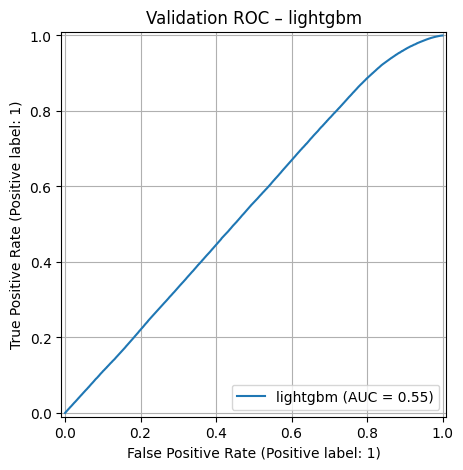

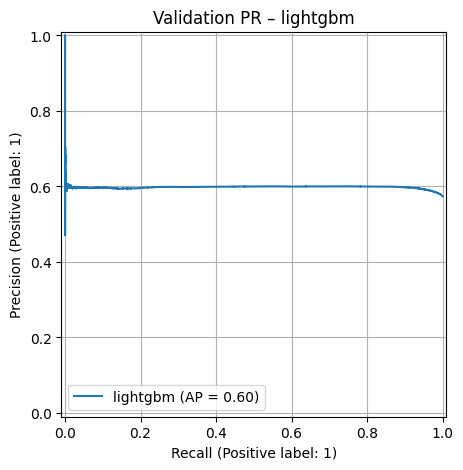

In [16]:
best_name = results_df.sort_values("val_auc", ascending=False).iloc[0]["model"]
best_model = models[best_name]

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

y_val_proba = best_model.predict_proba(X_val)[:, 1]

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_val, y_val_proba, name=best_name, ax=ax)
ax.set_title(f"Validation ROC – {best_name}")
plt.show()

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_val, y_val_proba, name=best_name, ax=ax)
ax.set_title(f"Validation PR – {best_name}")
plt.show()

In [17]:
test_metrics = evaluate_model(
    best_name,
    best_model,
    X_train,
    y_train,
    X_test,
    y_test,
)
test_metrics

/Users/utkarshsingh/ClickRank/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/utkarshsingh/ClickRank/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


{'model': 'lightgbm',
 'train_auc': 0.5993058716976447,
 'val_auc': 0.5466486484639084,
 'train_logloss': 0.6675826794184431,
 'val_logloss': 0.6722657560253307,
 'train_pr_auc': 0.6584053374229748,
 'val_pr_auc': 0.5988163671757663,
 'train_acc': 0.5994341666666667,
 'val_acc': 0.59682,
 'val_brier': 0.2397044755499522}

In [18]:
import joblib
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

model_path = MODELS_DIR / f"ctr_model_{best_name}.joblib"
joblib.dump(best_model, model_path)

model_path

PosixPath('models/ctr_model_lightgbm.joblib')